In [2]:
!nvidia-smi --query-gpu=power.draw --format=csv

power.draw [W]
3.10 W


In [3]:
# Before running this, we have to run the LLM as a separate server process with this command:
# python -m mlc_llm serve HF://mlc-ai/Qwen3-0.6B-q0f16-MLC
import requests
import time
import statistics
import pandas as pd
import glob
from pynvml import *
import threading
import subprocess
import psutil

def build_prompt(main_prompt):
    prompt = f'''
    Write a fictional short story based on the following prompt:
    {main_prompt}
    '''
    return prompt

df = pd.DataFrame(columns=['category', 'prompt', 'model_name', 'response', 'prompt_tokens', 'completion_tokens', 'prefill_tokens_per_s', 'decode_tokens_per_s', 'num_prefill_tokens', 'total_latency_s', 'throughput_tps', 'energy_consumed_uWh', 'avg_power_w', 'mem_peak_mb', 'start_time_s', 'end_time_s'])
df

/home/tonyi/miniconda3/envs/myenv/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/tmp/ipykernel_913/2495134102.py:8: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


,category,prompt,model_name,response,prompt_tokens,completion_tokens,prefill_tokens_per_s,decode_tokens_per_s,num_prefill_tokens,total_latency_s,time_to_first_token_s,throughput_tps,energy_consumed_uWh,avg_power_w,mem_peak_mb,start_time_s,end_time_s


In [4]:
import random
# Construct the prompt dataset
random.seed(1234)

prompt_dict = {
    'period_piece': [],
    'bad': [],
    'culture': [],
    'constraints1': [],
    'constraints2': []
}

misc_prompts = []

with open('prompt_set_misc.txt', 'r') as f:
    for line in f:
        misc_prompts.append(line)
# print(misc_prompts)

constraints_wording = []

with open('prompt_constraints1.txt', 'r') as f:
    for line in f:
        constraints_wording.append(line)
# print(constraints_wording)

constraints_style = []

with open('prompt_constraints2.txt', 'r') as f:
    for line in f:
        constraints_style.append(line)
# print(constraints_style)

for c in constraints_wording:
    base_prompt = misc_prompts[random.randrange(0, len(misc_prompts))]
    prompt_dict['constraints1'].append(f'{base_prompt} \n {c}')
print(prompt_dict['constraints1'])

for c in constraints_style:
    base_prompt = misc_prompts[random.randrange(0, len(misc_prompts))]
    prompt_dict['constraints2'].append(f'{base_prompt} \n {c}')
print(prompt_dict['constraints2'])

prompt_categories = ['period_piece', 'bad', 'culture']
for category in prompt_categories:
    with open(f'prompt_set_{category}.txt', 'r') as f:
        for line in f:
            prompt_dict[category].append(line)
    print(prompt_dict[category])

["You 're a Photographer who is able to stop time . You use that power to make incredible pictures ... tell me about it !\n \n Write the story without using the letter E.\n", 'You find a USB stick while waiting in an airport and claim it . You plug it in to wipe it , but find the title of a file too curious not to take a closer look…\n \n Write the story as a palindrome.\n', 'The boyband that you are in is breaking up and it is VERY dramatic .\n \n Write the story backwards, starting with the ending and ending with the beginning.\n', 'You find a USB stick while waiting in an airport and claim it . You plug it in to wipe it , but find the title of a file too curious not to take a closer look…\n \n Write the story as a dialogue, but one speaker can only ask questions.\n', 'The boyband that you are in is breaking up and it is VERY dramatic .\n \n Write the story where every sentence begins with the next letter of the alphabet, starting with A.\n', 'You find a USB stick while waiting in an

In [5]:
class GPUPowerSampler:
    """
    Samples GPU power and memory periodically.
    - Integrates power (reads milliwatts) to produce an energy accumulator (milliJoules).
    - Exposes energy in micro-watt-hours (uWh).
    - Computes average power in watts given a measured interval.
    - Samples GPU memory (start, end, peak) in MB.

    Backends: pynvml if available, otherwise nvidia-smi CLI.
    """
    def __init__(self, device_index=0, sample_interval=0.01):
        self.device_index = device_index
        self.sample_interval = sample_interval
        self._stop_event = threading.Event()
        self._thread = None

        # energy stored as millijoules (mJ) because we integrate mW * s -> mJ
        self._energy_mJ = 0.0
        self._last_time = None

        # memory tracking (bytes)
        self._mem_start_bytes = None
        self._mem_end_bytes = None
        self._mem_peak_bytes = 0

        # try pynvml
        try:
            import pynvml
            self._pynvml = pynvml
            self._pynvml.nvmlInit()
            self._handle = self._pynvml.nvmlDeviceGetHandleByIndex(self.device_index)
            self._backend = "pynvml"
        except Exception:
            self._pynvml = None
            self._handle = None
            self._backend = "nvidia-smi"
            # check nvidia-smi presence
            try:
                subprocess.run(["nvidia-smi", "--help"], capture_output=True, check=True)
            except Exception as e2:
                raise RuntimeError("Neither pynvml is available nor nvidia-smi found.") from e2

    def _read_power_mw(self):
        """
        Return instantaneous power in milliwatts (float).
        """
        if self._backend == "pynvml":
            try:
                # nvmlDeviceGetPowerUsage returns milliwatts (int)
                return float(self._pynvml.nvmlDeviceGetPowerUsage(self._handle))
            except Exception:
                return 0.0
        else:
            # nvidia-smi fallback: query power.draw in Watts then convert to mW
            try:
                out = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"],
                    capture_output=True, text=True, check=True
                )
                watts = float(out.stdout.strip().splitlines()[0])
                return watts * 1000.0
            except Exception:
                return 0.0

    def _read_memory_bytes(self):
        """
        Return current GPU memory used in bytes (int).
        If backend returns MiB, convert to bytes.
        """
        if self._backend == "pynvml":
            try:
                mem = self._pynvml.nvmlDeviceGetMemoryInfo(self._handle)
                return int(mem.used)
            except Exception:
                return 0
        else:
            # nvidia-smi fallback: query memory.used (usually in MiB)
            try:
                out = subprocess.run(
                    ["nvidia-smi", "--query-gpu=memory.used", "--format=csv,noheader,nounits"],
                    capture_output=True, text=True, check=True
                )
                # Typical output: "512 MiB" or "512"
                line = out.stdout.strip().splitlines()[0].strip()
                # remove possible "MiB"
                parts = line.split()
                val = float(parts[0])
                # assume val is MiB; convert to bytes
                return int(val * 1024.0 * 1024.0)
            except Exception:
                return 0

    def _run_sampler(self):
        # initialize integrator and memory baseline
        self._energy_mJ = 0.0
        self._last_time = time.perf_counter()

        # set start memory
        try:
            mb = self._read_memory_bytes()
            self._mem_start_bytes = mb
            self._mem_peak_bytes = mb
        except Exception:
            self._mem_start_bytes = 0
            self._mem_peak_bytes = 0

        while not self._stop_event.is_set():
            now = time.perf_counter()
            dt = now - self._last_time
            power_mw = self._read_power_mw()
            # energy (mJ) += power (mW) * dt (s)
            self._energy_mJ += power_mw * dt
            self._last_time = now

            # memory sampling
            mem = self._read_memory_bytes()
            if mem is not None:
                if self._mem_start_bytes is None:
                    self._mem_start_bytes = mem
                if mem > self._mem_peak_bytes:
                    self._mem_peak_bytes = mem

            # wait but allow early stop
            self._stop_event.wait(self.sample_interval)

        # final sample to close integration
        now = time.perf_counter()
        dt = now - self._last_time
        if dt > 0:
            power_mw = self._read_power_mw()
            self._energy_mJ += power_mw * dt
            self._last_time = now

        # final memory read
        try:
            mem = self._read_memory_bytes()
            if mem is not None:
                self._mem_end_bytes = mem
                if mem > self._mem_peak_bytes:
                    self._mem_peak_bytes = mem
        except Exception:
            # leave end/peak as they are
            pass

    def start(self):
        self._stop_event.clear()
        self._thread = threading.Thread(target=self._run_sampler, daemon=True)
        self._thread.start()

    def stop(self):
        self._stop_event.set()
        if self._thread is not None:
            self._thread.join()
            self._thread = None

    # --- exposed metrics helpers ---

    def energy_mJ(self):
        return self._energy_mJ

    def energy_uWh(self):
        """
        Convert accumulated millijoules (mJ) to micro-watt-hours (uWh).

        mJ -> J: /1000
        J -> Wh: /3600
        Wh -> uWh: *1e6

        Combined factor: mJ * (1e6 / (1000 * 3600)) = mJ * (1000 / 3600) = mJ * 0.277777...
        """
        return float(self._energy_mJ) * (1000.0 / 3600.0)

    def avg_power_w(self, total_time_s):
        """
        Compute average power (W) over total_time_s using accumulated energy.
        If total_time_s <= 0, return 0.
        """
        if total_time_s and total_time_s > 0:
            # energy in Joules = mJ / 1000
            energy_j = self._energy_mJ / 1000.0
            return energy_j / total_time_s
        return 0.0

    def mem_start_mb(self):
        if self._mem_start_bytes is None:
            return None
        return float(self._mem_start_bytes) / (1024.0 * 1024.0)

    def mem_end_mb(self):
        if self._mem_end_bytes is None:
            return None
        return float(self._mem_end_bytes) / (1024.0 * 1024.0)

    def mem_peak_mb(self):
        return float(self._mem_peak_bytes) / (1024.0 * 1024.0)

    def mem_delta_mb(self):
        if self._mem_start_bytes is None or self._mem_end_bytes is None:
            return None
        return (self._mem_end_bytes - self._mem_start_bytes) / (1024.0 * 1024.0)

    def shutdown(self):
        if self._pynvml:
            try:
                self._pynvml.nvmlShutdown()
            except Exception:
                pass

In [8]:
sampler = GPUPowerSampler(device_index=0, sample_interval=0.01)

max_tokens = 300

models = ["SmolLM2-135M-Instruct-q0f16-MLC"]

for model in models:
    for category in prompt_dict.keys():
        for prompt in prompt_dict[category]:
            final_prompt = build_prompt(prompt)
            payload = {
                    "model": f"HF://mlc-ai/{model}",
                    "messages": [{"role": "user", "content": final_prompt}],
                    "max_tokens": max_tokens,
                    # "stream_options" : {"include_usage" = true},
                    # "logprobs": True,
                    # "top_logprobs": 2
                }

            sampler.start()
            t0 = time.perf_counter()
            content = ""
            usage = None
            print("Sending request with prompt:")
            print(final_prompt)
            try:
                r = requests.post("http://127.0.0.1:8000/v1/chat/completions", json=payload)
                r.raise_for_status()
                resp = r.json()
                print(resp)
                # safe dict access (adjust according to your server's schema)
                choices = resp.get("choices") or resp.get("result") or []
                if choices:
                    # adapt depending on structure; this attempts common shapes
                    first = choices[0]
                    # prefer nested structure like {"message": {"content": "..."}}
                    if isinstance(first, dict):
                        msg = first.get("message") or first.get("delta") or {}
                        if isinstance(msg, dict) and "content" in msg:
                            content = msg.get("content", "")
                        else:
                            # fallback: try 'text' or 'content' at top level
                            content = first.get("content") or first.get("text") or content
                    else:
                        # if choice is plain string
                        content = str(first)
                usage = resp.get("usage") or {}
                
            finally:
                # Stop sampler after response or on exception
                t1 = time.perf_counter()
                sampler.stop()

            # parse usage robustly
            prompt_tokens = 0
            completion_tokens = 0
            prefill_tok_s = 0
            decode_tok_s = 0
            num_prefill_tokens = 0

            if usage:
                # usage might be a dict or object; be defensive
                if isinstance(usage, dict):
                    prompt_tokens = int(usage.get("prompt_tokens", 0) or 0)
                    completion_tokens = int(usage.get("completion_tokens", 0) or 0)
                    extra = usage.get("extra", {}) or {}
                    if isinstance(extra, dict):
                        prefill_tok_s = float(extra.get("prefill_tokens_per_s", 0) or 0)
                        decode_tok_s = float(extra.get("decode_token_per_s", 0) or 0)
                        num_prefill_tokens = int(extra.get("num_prefill_tokens", 0) or 0)

            total_tokens = prompt_tokens + completion_tokens
            latency_s = t1 - t0

            # energy and power
            energy_uWh = sampler.energy_uWh()
            avg_power_w = sampler.avg_power_w(latency_s)

            # memory metrics (MB)
            mem_start_mb = sampler.mem_start_mb()
            mem_end_mb = sampler.mem_end_mb()
            mem_peak_mb = sampler.mem_peak_mb()
            mem_delta_mb = sampler.mem_delta_mb()

            throughput = 0.0
            if latency_s > 0:
                throughput = completion_tokens / latency_s

            new_row = pd.DataFrame([{
                "category": category,
                "prompt": prompt,
                "model_name": model,
                "response": content,
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "prefill_tokens_per_s": prefill_tok_s,
                "decode_tokens_per_s": decode_tok_s,
                "num_prefill_tokens": num_prefill_tokens,
                "total_latency_s": latency_s,
                "throughput_tps": throughput,
                "energy_consumed_uWh": energy_uWh,
                "avg_power_w": avg_power_w,
                "mem_peak_mb": mem_peak_mb,
                "start_time_s": t0,
                "end_time_s": t1
            }])
        
            df = pd.concat([df, new_row], ignore_index=True)
            print("processing time: ", latency_s)
            
        
    
            
            
sampler.shutdown()

df.to_csv("gpu_prompt_results.csv", index=False)
print("All done")
df

Sending request with prompt:

    Write a fictional short story based on the following prompt:
    Bill Clinton lives under your bed . Describe a weekend in your life

    
{'id': 'chatcmpl-2ee80db72d0640909f331829c05f32aa', 'choices': [{'finish_reason': 'length', 'index': 0, 'message': {'content': 'It was a !pooficillinase!pooffounderpuffritase Berezney!021 distinguishes the smellPoofprotein-iosity smellspoofSWP hier011Ppoof SARPoft modern- marriagePoof0011Ppoof guessyouPoof01 wouldreallyP j / /PasePoo connectwithPooasePoopoo4PoofP FoundationPberslavpoof would@housePoof011PpoofnelFpoof reheasejoyfulPoof0011Ppoof Devaspoo11Ppoo biPoof614amppPoo20110 terms souvenirt j / /PoseompFoo2/ secretionPoo111PPoo78PpoofibilitiesPupppoof920PpoolsPoozejoyTemp pluralismP@ agoPoofP biPi2011DraftPoofutableiosityPoftsoPooPpoof terms DNApoofP tireP lasersUnionBritPooFtPsequ@ PolophorePooPoof2011PpooPova AdolescPp41- malePooDpoof11-IPoBasePoofPuppoPpoofM DespiteMedical tackleDispoop bi ErnstSwPPooالpoofP

,category,prompt,model_name,response,prompt_tokens,completion_tokens,prefill_tokens_per_s,decode_tokens_per_s,num_prefill_tokens,total_latency_s,time_to_first_token_s,throughput_tps,energy_consumed_uWh,avg_power_w,mem_peak_mb,start_time_s,end_time_s,start_time_ms,end_time_ms
0,period_piece,Bill Clinton lives under your bed . Describe a...,SmolLM2-135M-Instruct-q0f16-MLC,As she lay in bed spent helter-skelterPursing ...,56,300,0.0,0.0,0,93.420357,NaN,3.211292,80895.406567,3.117345,134.000000,NaN,NaN,674.450224,767.870581
1,period_piece,Bill Clinton lives under your bed . Describe a...,SmolLM2-135M-Instruct-q0f16-MLC,It was a !pooficillinase!pooffounderpuffritase...,56,300,0.0,0.0,0,106.819734,NaN,2.808470,92450.619328,3.115737,134.000000,NaN,NaN,1302.510633,1409.330367
2,period_piece,Today I found a 1949 British Shilling in my ch...,SmolLM2-135M-Instruct-q0f16-MLC,Title: stairwell surprise\n\n--- voids Script ...,97,300,0.0,0.0,0,117.669320,NaN,2.549518,101632.132409,3.109355,194.441406,NaN,NaN,1409.342837,1527.012157
3,period_piece,A world where Pangea never broke up,SmolLM2-135M-Instruct-q0f16-MLC,"Once upon a time, in a land far, far away, the...",52,300,0.0,0.0,0,113.530707,NaN,2.642457,98023.844447,3.108285,178.777344,NaN,NaN,1527.025006,1640.555714
4,bad,A suicidal person steps out on to the ledge of...,SmolLM2-135M-Instruct-q0f16-MLC,"Panic set inPanic tablespPpix engines,ritoPrip...",98,300,0.0,0.0,0,120.911926,NaN,2.481145,104413.435948,3.108778,164.886719,NaN,NaN,1640.561247,1761.473173
5,bad,You are a Genie . The last time someone let yo...,SmolLM2-135M-Instruct-q0f16-MLC,Title: deathp toings�⁣rit versions\n\nGreeting...,109,300,0.0,0.0,0,120.552700,NaN,2.488538,104137.286923,3.109795,164.886719,NaN,NaN,1761.484926,1882.037626
6,bad,The Slaver and his Boy\n,SmolLM2-135M-Instruct-q0f16-MLC,Once upon a timePantanPascalPascalPascalLiam A...,50,300,0.0,0.0,0,114.064771,NaN,2.630085,98523.692394,3.109508,164.886719,NaN,NaN,1882.042894,1996.107665
7,bad,"You are suicidal , however , you are also immo...",SmolLM2-135M-Instruct-q0f16-MLC,You are startledteristan01PBS one These rectil...,59,58,0.0,0.0,0,22.042134,NaN,2.631324,19035.561137,3.108956,164.886719,NaN,NaN,1996.114472,2018.156606
8,bad,"A satanist tries to summon Satan , but summons...",SmolLM2-135M-Instruct-q0f16-MLC,"p.s. Odta, aolution.",58,11,0.0,0.0,0,4.736991,NaN,2.322149,4090.200370,3.108455,164.886719,NaN,NaN,2018.160684,2022.897675
9,bad,It 's nearly the end of World War 3 . Moskow/W...,SmolLM2-135M-Instruct-q0f16-MLC,It was the doctor's last breath.terribly spend...,82,300,0.0,0.0,0,125.300562,NaN,2.394243,108203.330123,3.108781,164.886719,NaN,NaN,2022.901558,2148.202121


In [9]:
mem_peak_mb

164.88671875

In [10]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 3.2 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [6]:
X = df.drop(columns=['Energy(mJ)', "Latency(s)"])
y = df['Energy(mJ)']

X

,PT,GT
0,64,16
1,64,64
2,64,128
3,256,16
4,256,64
5,256,128
6,512,16
7,512,64
8,512,128
9,1024,16


In [7]:
m = LinearRegression().fit(X, y)
print(m.coef_, m.intercept_)

[  50.4716535  1665.08375121] 8867.765162548138


In [9]:
y_pred = m.predict(X)

mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 13455.873900511593
MAPE: 0.09743898765244924


In [11]:
y_pred

array([ 38739.29100593, 118663.31106407, 225228.6711416 ,  48429.84847791,
       128353.86853606, 234919.22861358,  61350.59177389, 141274.61183204,
       247839.97190956,  87192.07836586, 167116.098424  , 273681.45850153])

In [10]:
from matplotlib import pyplot as plt

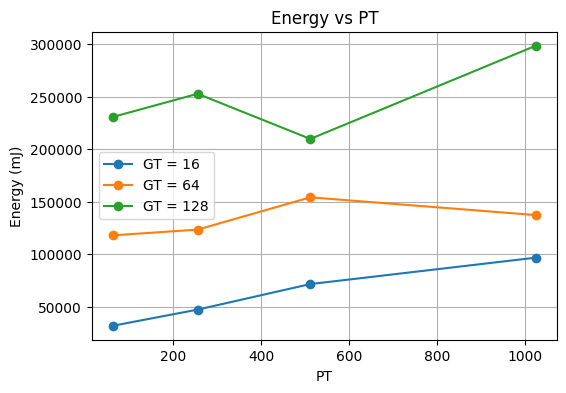

In [22]:
# Energy vs PT for fixed GT

plt.figure(figsize=(6,4))
for g in generated_tokens:
    subset = df[df["GT"] == g]
    plt.plot(subset["PT"], subset["Energy(mJ)"], 'o-', label=f"GT = {g}")
plt.xlabel("PT")
plt.ylabel("Energy (mJ)")
plt.title(f"Energy vs PT")
plt.legend()
plt.grid(True)
plt.show()

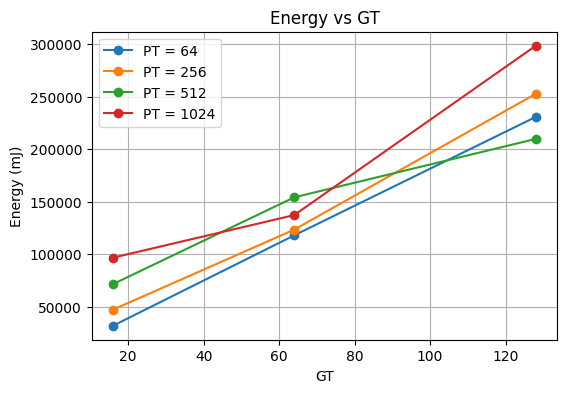

In [21]:
# Energy vs GT for fixed PT

plt.figure(figsize=(6,4))
for p in prompt_token_counts:
    subset = df[df["PT"] == p]
    plt.plot(subset["GT"], subset["Energy(mJ)"], 'o-', label=f"PT = {p}")
plt.xlabel("GT")
plt.ylabel("Energy (mJ)")
plt.title(f"Energy vs GT")
plt.legend()
plt.grid(True)
plt.show()

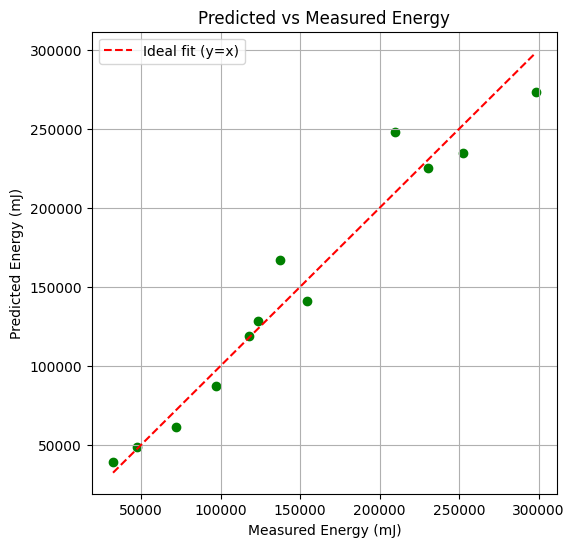

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(df["Energy(mJ)"], y_pred, color='green')
plt.plot([df["Energy(mJ)"].min(), df["Energy(mJ)"].max()],
         [df["Energy(mJ)"].min(), df["Energy(mJ)"].max()],
         'r--', label="Ideal fit (y=x)")
plt.xlabel("Measured Energy (mJ)")
plt.ylabel("Predicted Energy (mJ)")
plt.title("Predicted vs Measured Energy")
plt.legend()
plt.grid(True)
plt.show()
